In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.densenet import preprocess_input

In [2]:
# Imports for image transformations
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation

In [22]:
data_dir = '../data/raw/COVID-19_Radiography_Dataset/'
train_ds = image_dataset_from_directory(data_dir, validation_split=0.2, subset='training', seed=42, batch_size=16, image_size=(64, 64))
val_ds = image_dataset_from_directory(data_dir, validation_split=0.2, subset='validation', seed=42, batch_size=16, image_size=(64, 64))

Found 42330 files belonging to 4 classes.
Using 33864 files for training.
Found 42330 files belonging to 4 classes.
Using 8466 files for validation.


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01, verbose=1, mode='min', monitor='val_loss')
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.01, factor=0.1, cooldown=4, verbose=1)

In [24]:
class_names = val_ds.class_names
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

In [25]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # freeze weights initially

#for layer in base_model.layers[-4:]:
#    layer.trainable = True

inputs = Input(shape=(64, 64, 3))
x = RandomRotation(0.1)(inputs)
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomFlip('horizontal')(x)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)  # classification

dense_model = Model(inputs=inputs, outputs=outputs)
dense_model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
training_history = dense_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1, callbacks=[early_stopping, reduce_learning_rate], shuffle=True)

Epoch 1/50
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 268s 122ms/step - accuracy: 0.6470 - loss: 0.8817 - val_accuracy: 0.7458 - val_loss: 0.6423 - learning_rate: 1.0000e-04
Epoch 2/50
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 238s 112ms/step - accuracy: 0.7385 - loss: 0.6567 - val_accuracy: 0.7555 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 3/50
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 247s 117ms/step - accuracy: 0.7607 - loss: 0.6065 - val_accuracy: 0.7642 - val_loss: 0.5990 - learning_rate: 1.0000e-04
Epoch 4/50
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 241s 114ms/step - accuracy: 0.7709 - loss: 0.5743 - val_accuracy: 0.7707 - val_loss: 0.5851 - learning_rate: 1.0000e-04
Epoch 5/50
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 242s 114ms/step - accuracy: 0.7814 - loss: 0.5494 - val_accuracy: 0.7726 - val_loss: 0.5732 - learning_rate: 1.0000e-04
Epoch 6/50
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 244s 115ms/step - accuracy: 0.7942 - loss: 0.5225 - val_accuracy: 0.7794 - val_loss: 0.5653 - learning_rate: 1.0000e-04
Epoch 7/50
2117/2117 ━━━━━━━

In [27]:
dense_model.save('../models/densenet121_model.keras')
#dense_model.save('../models/densenet121_model_trainable.keras')

In [28]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = dense_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [29]:
print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

          COVID       0.81      0.56      0.66      1467
   Lung_Opacity       0.76      0.76      0.76      2408
         Normal       0.80      0.90      0.85      4046
Viral Pneumonia       0.88      0.88      0.88       545

       accuracy                           0.80      8466
      macro avg       0.81      0.77      0.79      8466
   weighted avg       0.80      0.80      0.79      8466



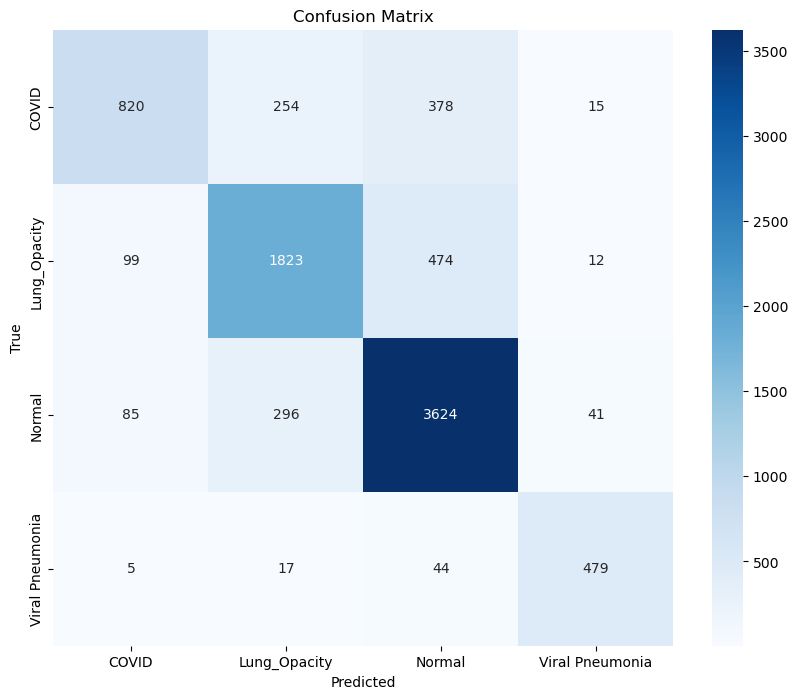

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [32]:
from tensorflow.keras.models import load_model
unfrozen_model = load_model('../models/densenet121_model_trainable.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

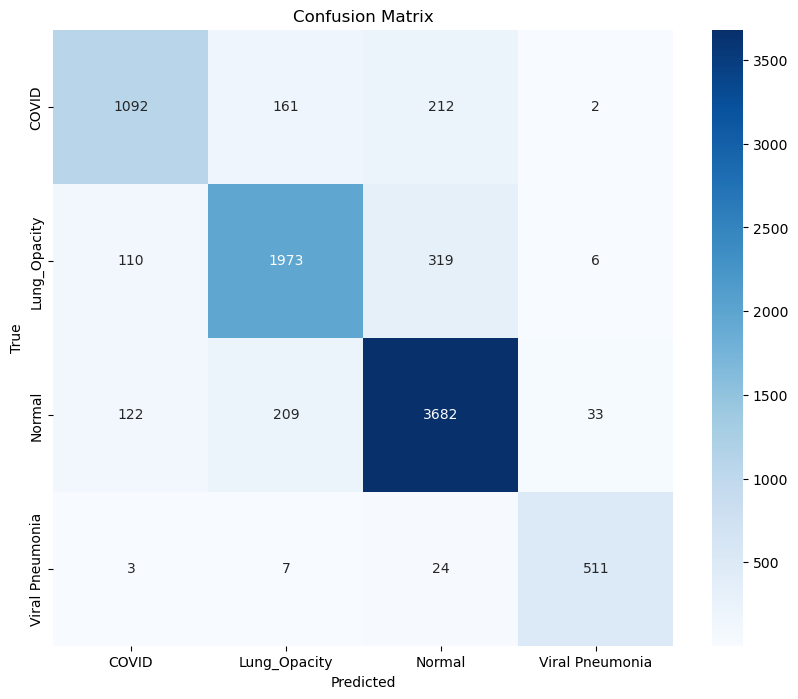

In [33]:
y_true1 = []
y_pred1 = []

for images, labels in val_ds:
    preds = unfrozen_model.predict(images)
    y_true1.extend(labels.numpy())
    y_pred1.extend(np.argmax(preds, axis=1))

print(classification_report(y_true1, y_pred1, target_names=class_names))

cm = confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [34]:
print(classification_report(y_true1, y_pred1, target_names=class_names))

                 precision    recall  f1-score   support

          COVID       0.82      0.74      0.78      1467
   Lung_Opacity       0.84      0.82      0.83      2408
         Normal       0.87      0.91      0.89      4046
Viral Pneumonia       0.93      0.94      0.93       545

       accuracy                           0.86      8466
      macro avg       0.86      0.85      0.86      8466
   weighted avg       0.86      0.86      0.86      8466

